## 0.0 IMPORTS

In [73]:
import pandas                as pd
import numpy                 as np
import inflection
import math
from   scipy                 import stats
import seaborn               as sns
import matplotlib.pyplot     as plt

from   IPython.display       import Image
from   IPython.core.display  import HTML
import datetime

from   sklearn.preprocessing import RobustScaler
from   sklearn.preprocessing import MinMaxScaler

### 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descriçao dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#raname

df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
# df1.dtypes   / Coluna date foi importada como 'object'

df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA


In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance

df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month

df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year 

df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2                        

#promo2_since_week

df1['promo2_since_week']= df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)          

#promo2_since_year

df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)            

#promo_interval

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )



## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


## 1.6. Descriptive Statistical

In [15]:
df1.describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.935443e+03,6.786849e+00,2.010325e+03,5.005638e-01,2.361903e+01,2.012793e+03,1.552306e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,1.254765e+04,3.311087e+00,5.515593e+00,4.999999e-01,1.431006e+01,1.662658e+00,3.621246e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000e+00,2.008000e+03,0.000000e+00,1.200000e+01,2.012000e+03,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,7.000000e+00,2.012000e+03,1.000000e+00,2.200000e+01,2.013000e+03,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.910000e+03,1.000000e+01,2.014000e+03,1.000000e+00,3.700000e+01,2.014000e+03,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+05,1.200000e+01,2.015000e+03,1.000000e+00,5.200000e+01,2.015000e+03,1.000000e+00


In [16]:
num_atributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_atributes.apply(np.median)).T


# Dispersion std, min, range, skew, kurtosis

d1 = pd.DataFrame (num_atributes.apply (np.std)).T
d2 = pd.DataFrame (num_atributes.apply( min)).T
d3 = pd.DataFrame (num_atributes.apply( max)).T
d4 = pd.DataFrame (num_atributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_atributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame (num_atributes.apply(lambda x: x.kurtosis())).T

# concatenete
m = pd.concat ([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [19]:
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

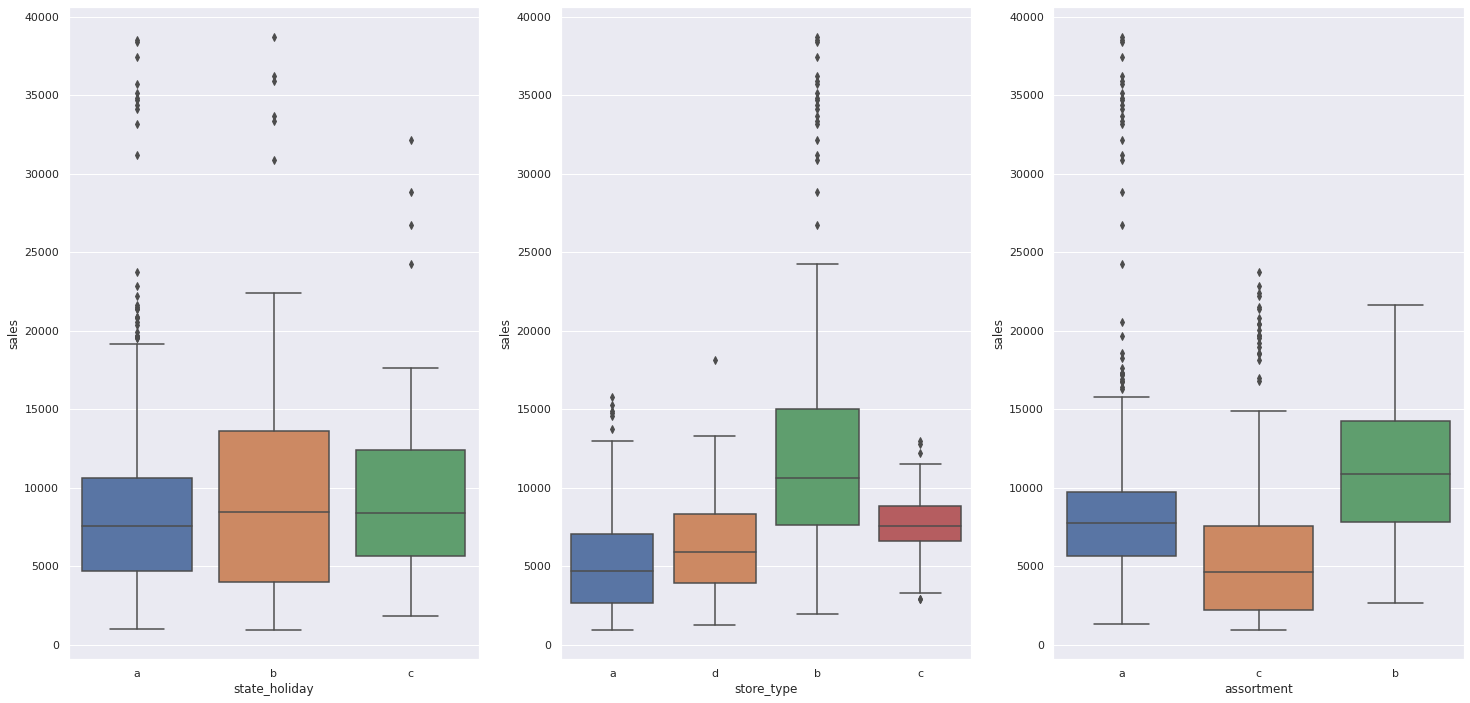

In [20]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]



plt.subplot(131)
sns.boxplot(x = 'state_holiday', y='sales', data= aux1)

plt.subplot(132)
sns.boxplot(x = 'store_type', y='sales', data= aux1)

plt.subplot(133)
sns.boxplot(x = 'assortment', y='sales', data= aux1)

# 2.0 Feature Enginnering

In [21]:
df2 = df1.copy()

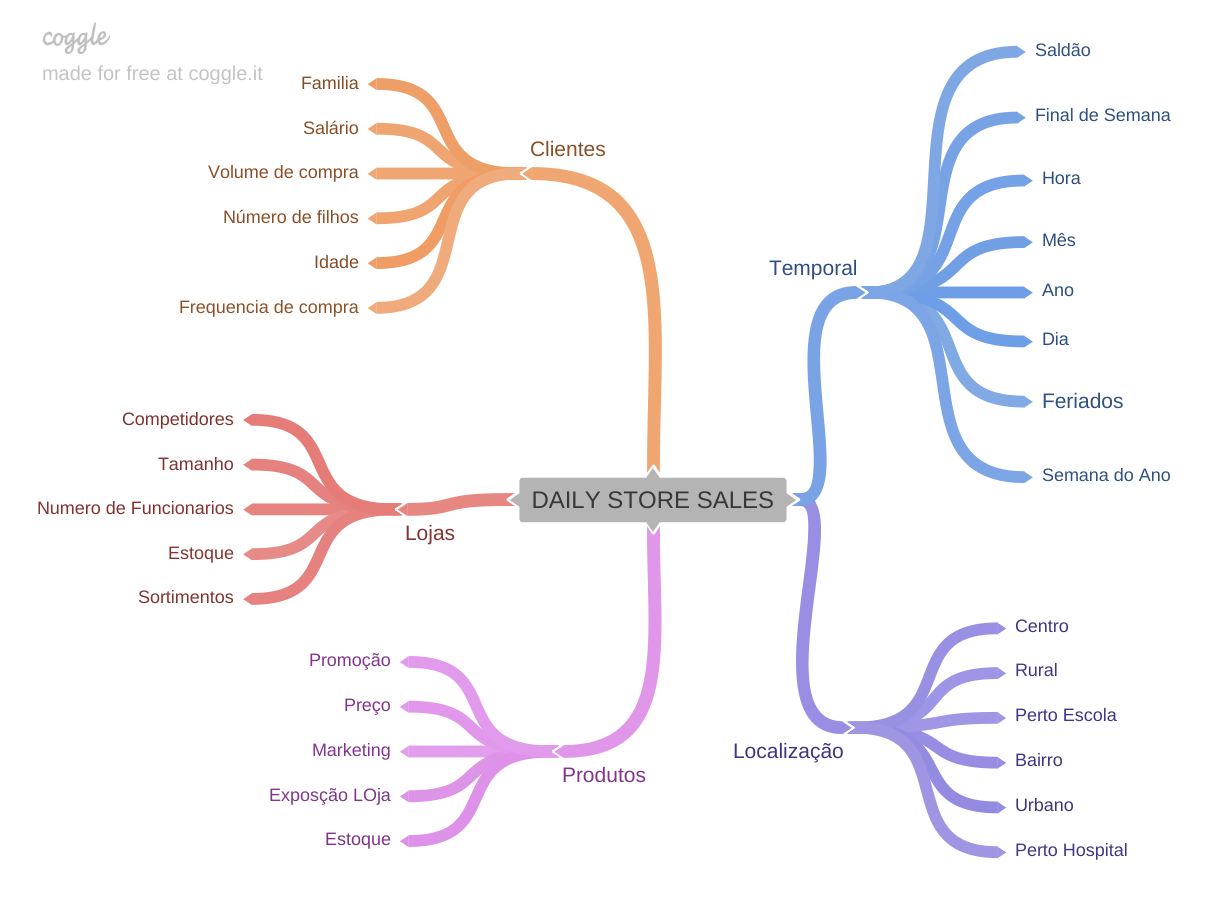

In [22]:
Image('imagem/MapaMentalHiposteses.png')

## 2.1 Mapa Mental de Hipoteses

### 2.1.1 Hipoteses da Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.1.2 Hipoteses da Produto

**1.** Lojas que investem mais em Markering deveriam vender mais.

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas com precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo nos produtos deveriam vender mais.



### 2.1.3 Hipoteses Tempo


**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos finais de semana deveriam vender mais

**3.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.





## 2.1 Mapa Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Enginnering

In [23]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) 
df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since']) /7 ).apply(lambda x : x.days).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x== 'c' else 'regular_day')


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3['assortment'].value_counts()

basic       537445
extended    471470
extra         8294
Name: assortment, dtype: int64

### 3.1. PASSO 03 - FILTRAGEM DAS LINHAS

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

### 3.0. PASSO 03 - FILTRAGEM DE COLUNAS

In [27]:
cols_drop = ["customers", 'open', 'promo_interval', 'month_map']

In [28]:
df3.drop(cols_drop, axis=1, inplace=True)

In [29]:
df3.shape

(844338, 25)

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [30]:
df4 = df3.copy()

### 4.1. PASSO 04 - ANÁLISE UNIVARIADA

#### 4.1.1 RESPONSE VARIABLE

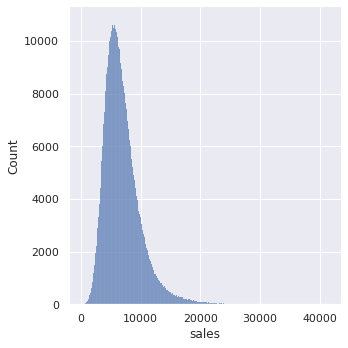

In [31]:
sns.displot(df4['sales'])

#### 4.1.1 NUMERICAL VARIABLE

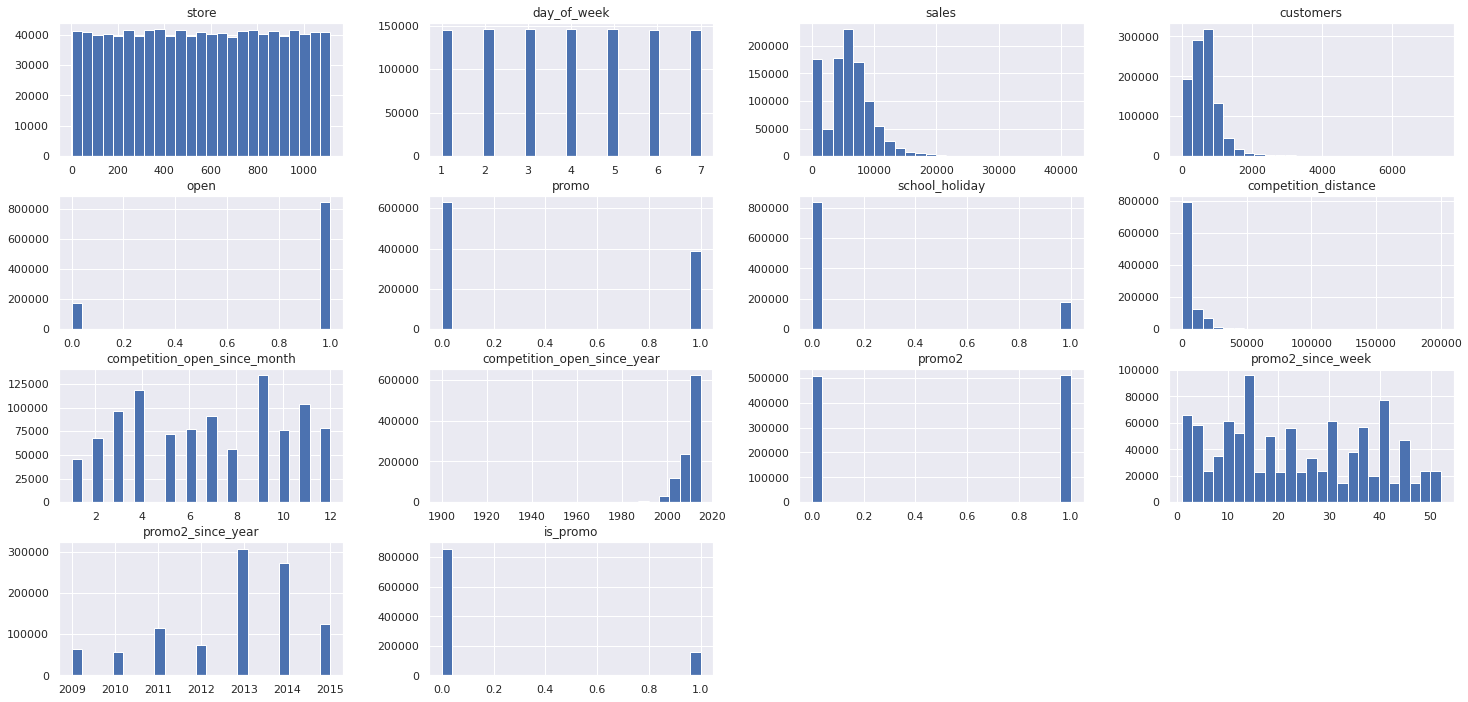

In [32]:

num_atributes.hist(bins=25);

#### 4.1.3 CATEGORICAL VARIABLE

/home/igor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/igor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/igor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


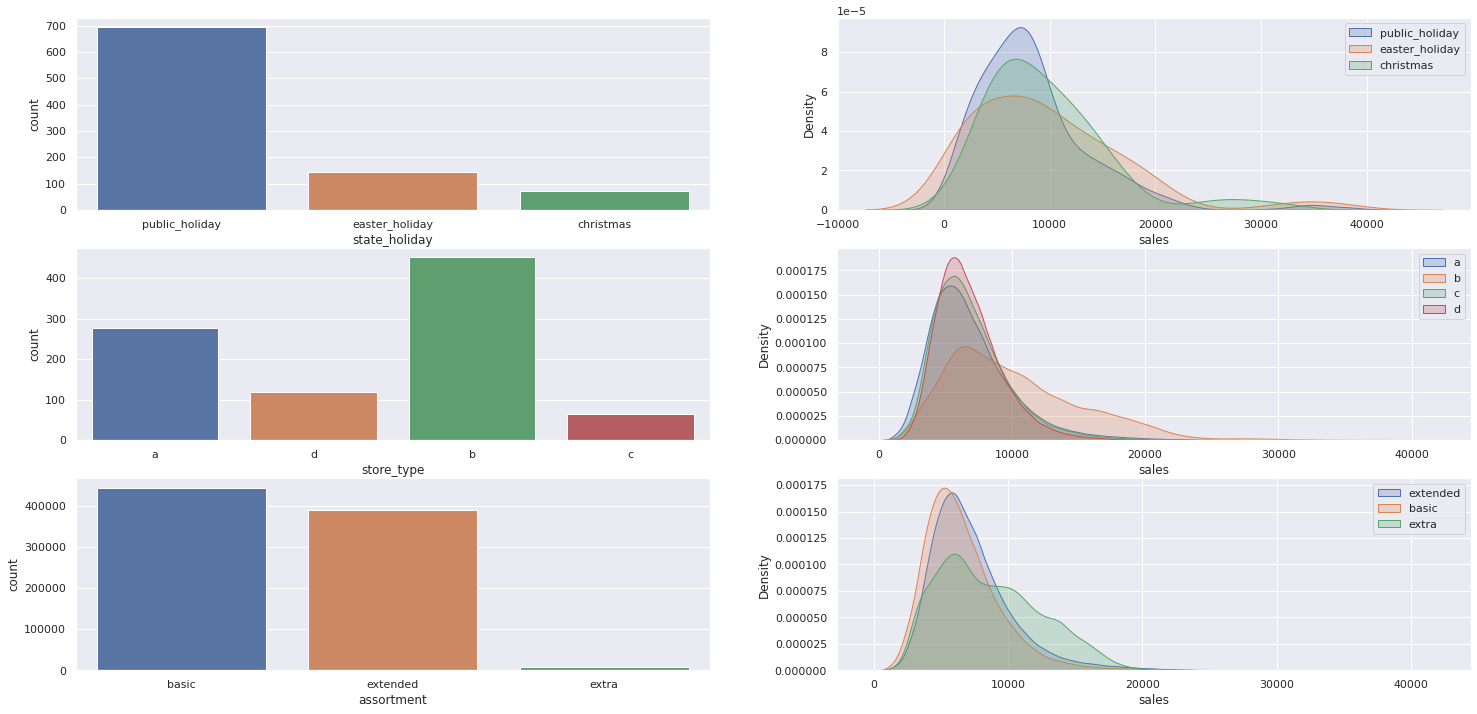

In [33]:
# state_holiday
plt.subplot(321)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(322)

sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

#story_type
plt.subplot(323)
sns.countplot(a['store_type'])

plt.subplot(324)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()
#assortment
plt.subplot(325)
sns.countplot(df4['assortment'])



plt.subplot(326)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ="basic", shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)
plt.legend()



### 4.2 PASSO 04 - ANÁLISE BIVARIADA

#### H1. Lojas com maior sortimentos deveriam vender mais.

**Falsa** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

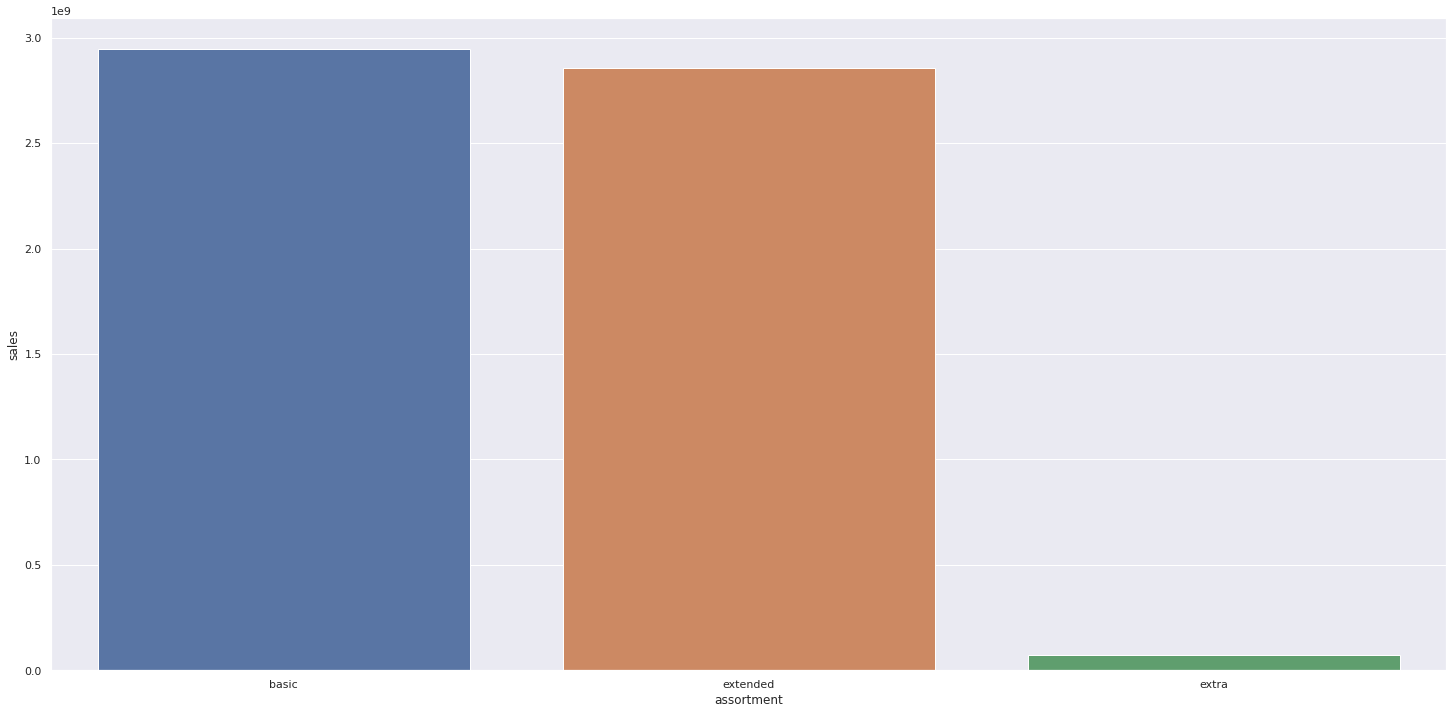

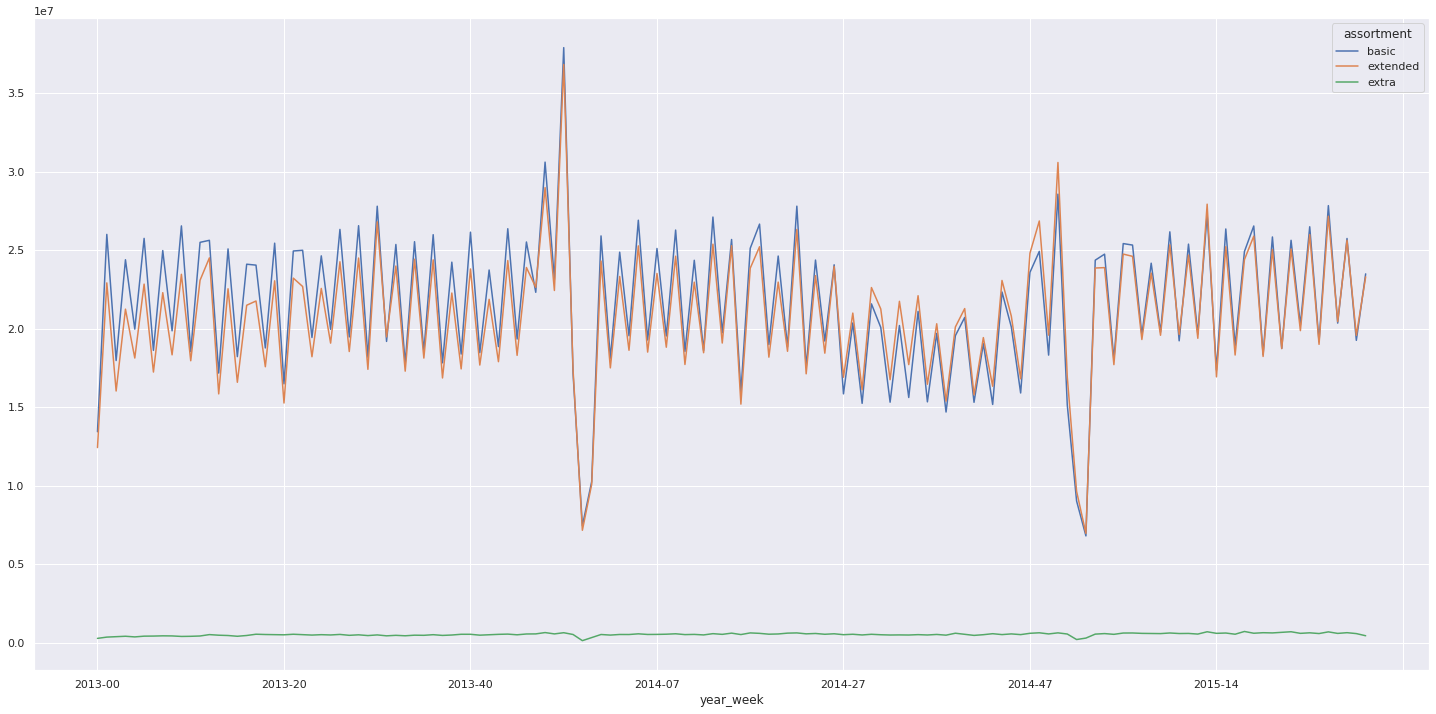

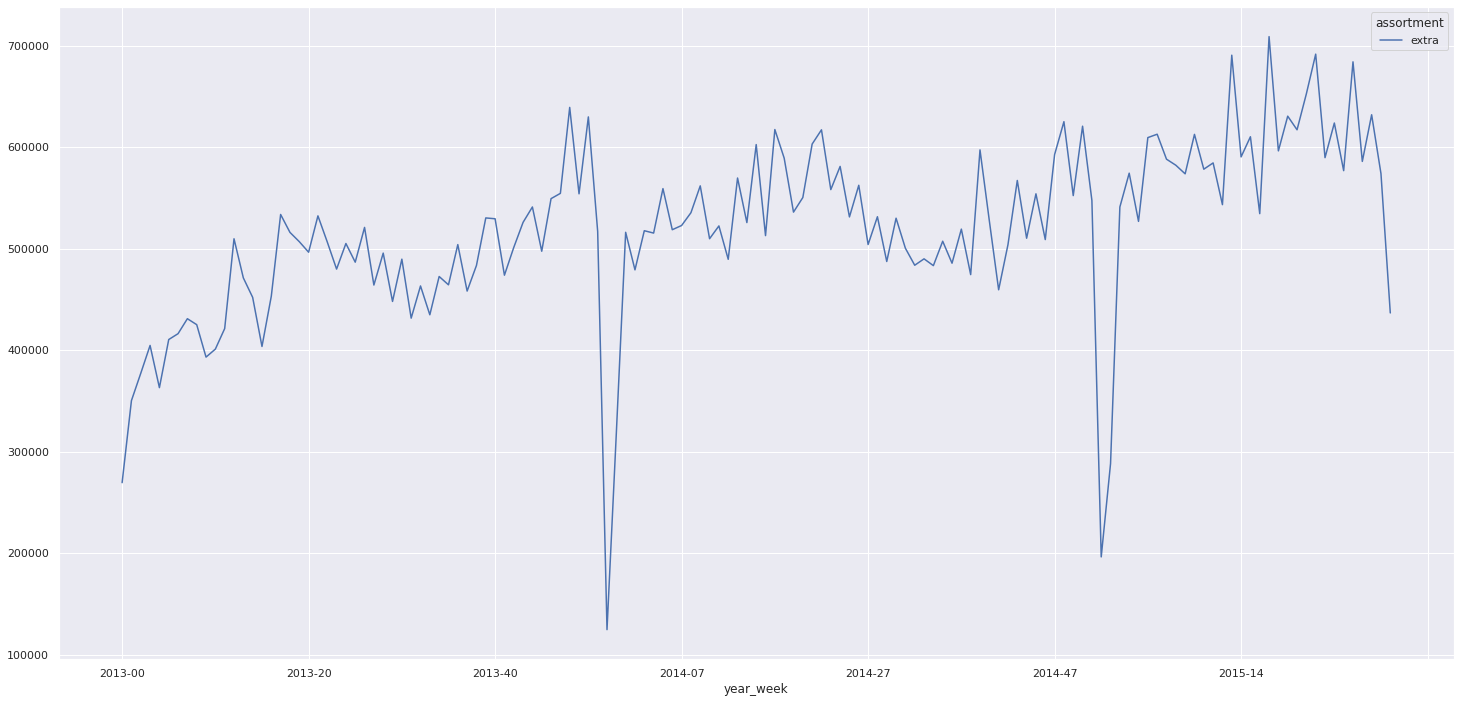

In [34]:
aux1= df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y ='sales', data= aux1);

aux2= df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week',columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** LOjas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


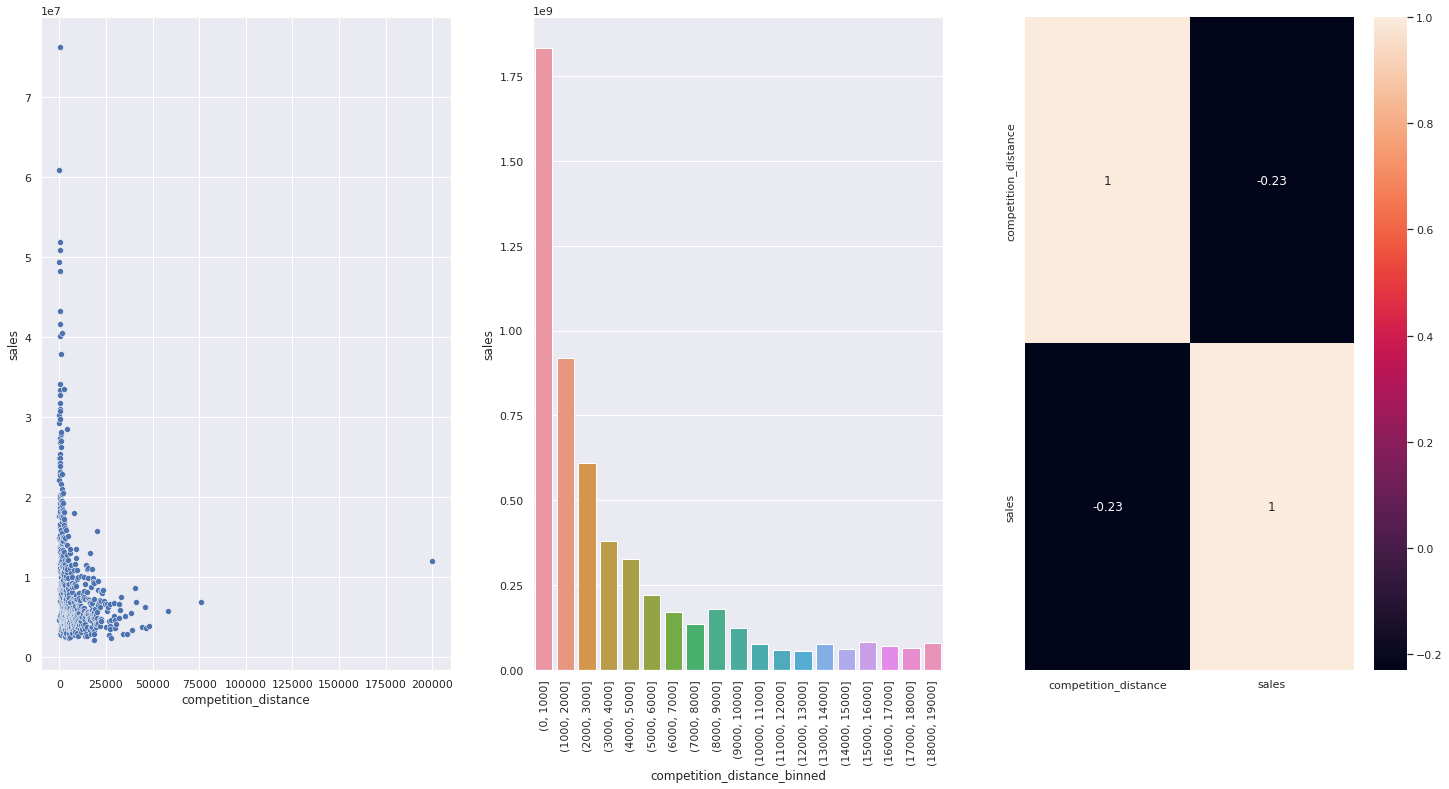

In [35]:
aux1 = df4[['competition_distance','sales']].groupby ('competition_distance').sum().reset_index()

plt.subplot(131)
sns.scatterplot(x='competition_distance', y= 'sales', data = aux1)

plt.subplot(132)

bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned', y='sales', data = aux2)
plt.xticks(rotation=90)

plt.subplot(133)

sns.heatmap( aux1.corr(method='pearson'), annot=True);

#### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**Falsa** Lojas com competidores a MAIS tempo vendem MENOS



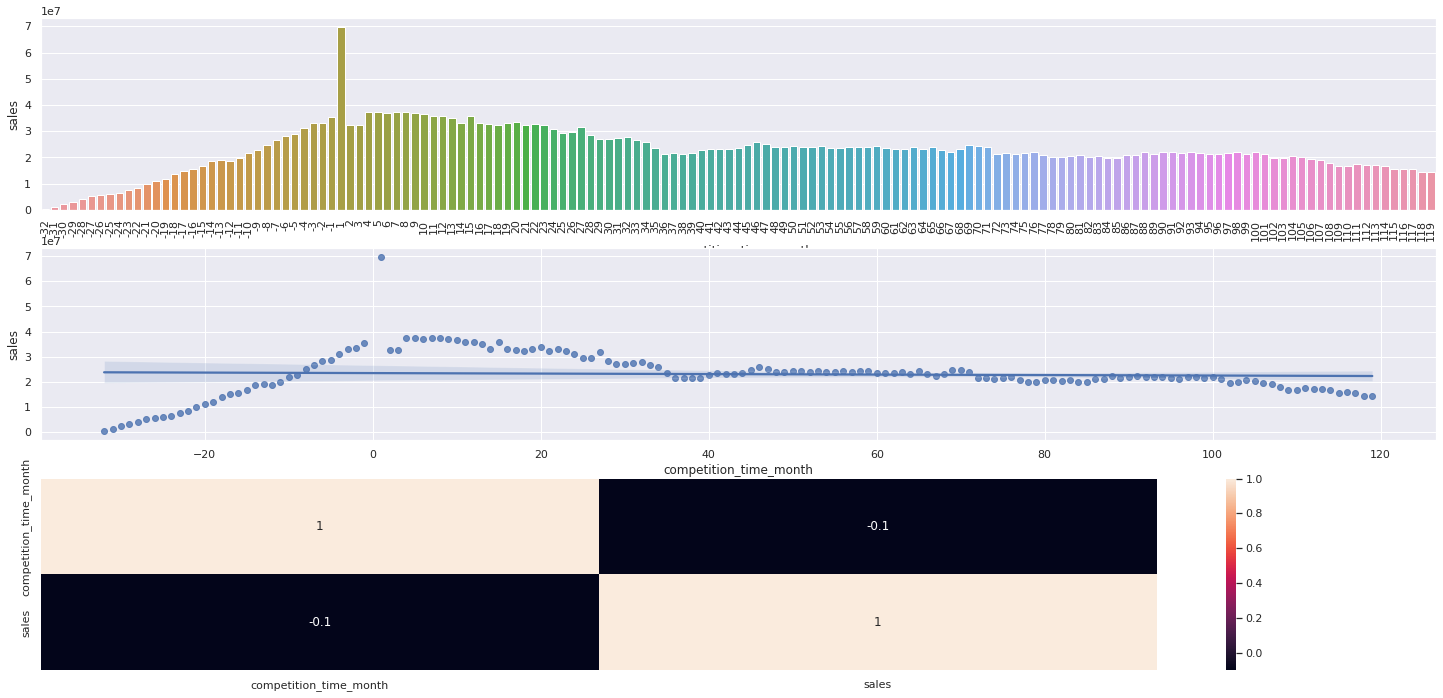

In [36]:
plt.subplot(311)
aux1=df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(312)
sns.regplot(x='competition_time_month', y='sales', data= aux2)

plt.subplot(313)
sns.heatmap( aux1.corr(method='pearson'),annot=True);


In [37]:
aux1['competition_time_month'].sample(5)

328    635
260    229
222    190
313    303
190    158
Name: competition_time_month, dtype: int64

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoçoes ativas por MAIS tempo vendem MENOS, depois de um certo periodo de promoção.


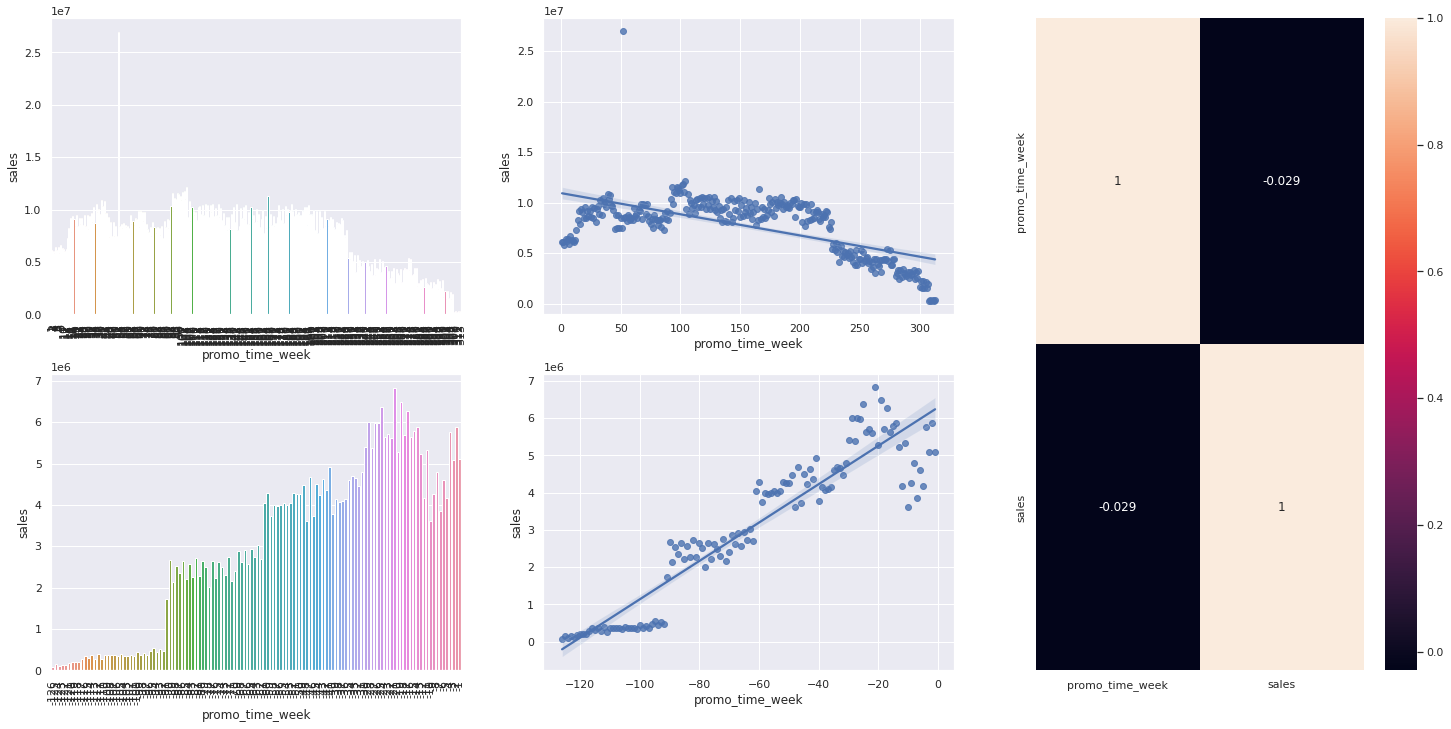

In [38]:
aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data= aux1)

grid = GridSpec(2,3)

plt.subplot( grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot(x='promo_time_week', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])

sns.regplot(x='promo_time_week', y='sales', data= aux2)

plt.subplot(grid[1,0])

aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot(x='promo_time_week', y='sales', data= aux3)
plt.xticks(rotation=90);



plt.subplot(grid [1,1])
sns.regplot(x='promo_time_week', y='sales', data= aux3);


plt.subplot(grid [:,2])

sns.heatmap( aux1.corr( method='pearson'),annot=True);



#### <s> 5. Lojas com mais dias de promoção deveriam vender mais. </s>



#### 7. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com MAIS promoçoes concecutias devem vende MENOS.

In [39]:
df4[['promo', 'promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


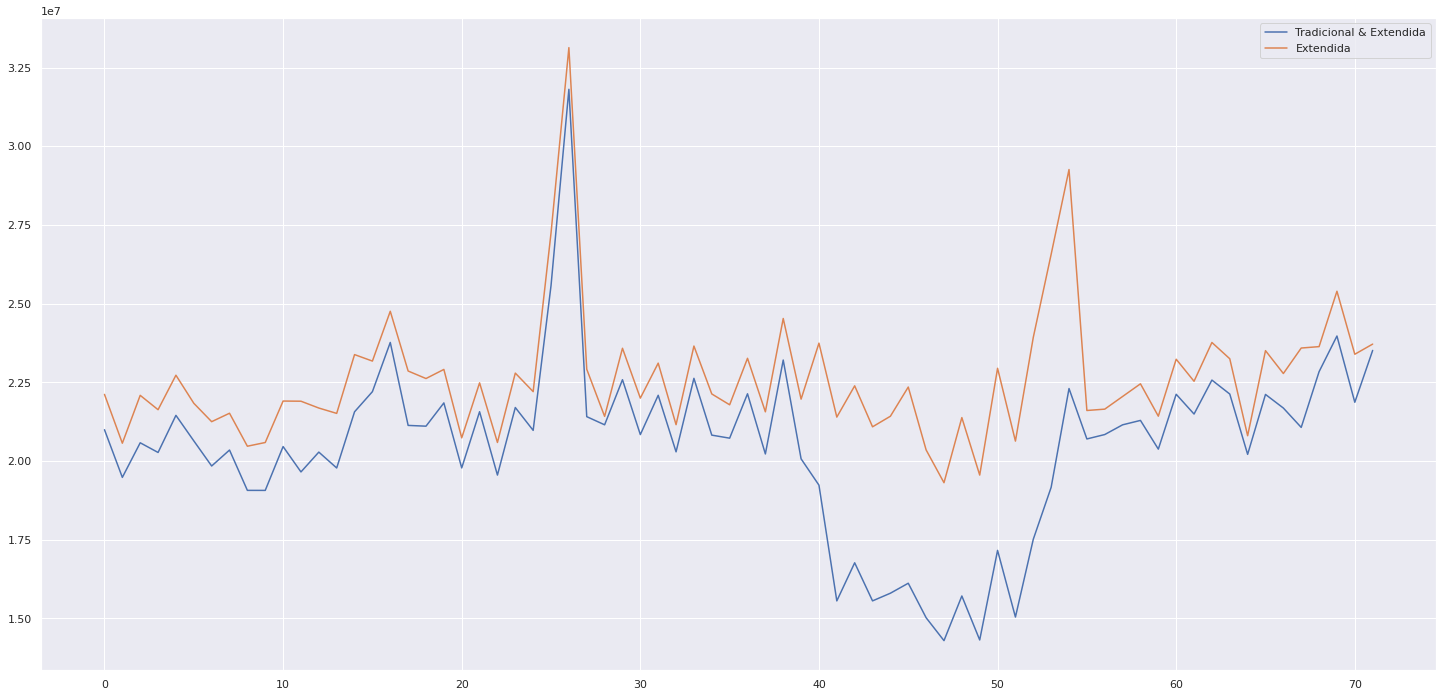

In [40]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

#### 8. H Lojas abertas durante o feriado de Natal deveriam vender mais.

***FALSA*** Lojas abertas durante o natal VENDEM MENOS




In [41]:
aux= df4[df4['state_holiday'] != 'regular_day']

<AxesSubplot:xlabel='year', ylabel='sales'>

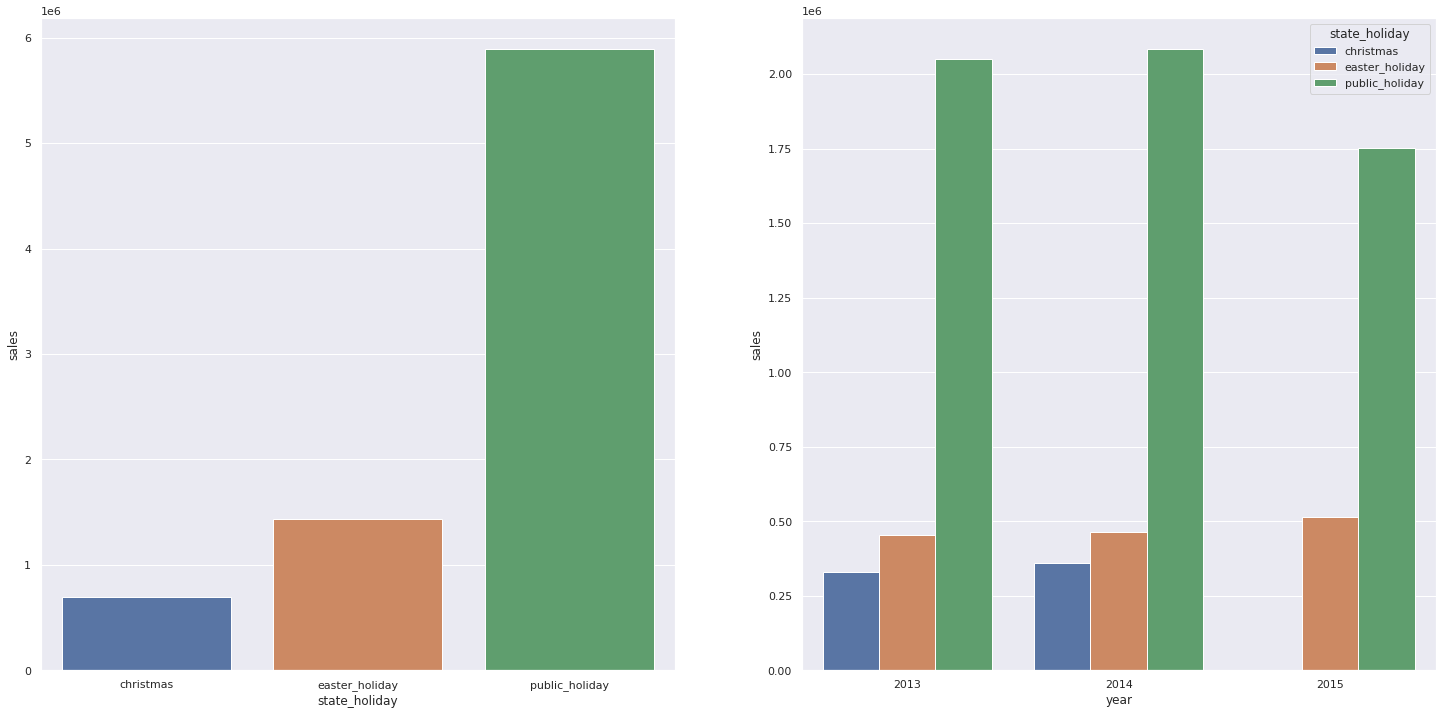

In [42]:

aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(121)
sns.barplot(x='state_holiday', y ='sales', data = aux1)


plt.subplot(122)

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y ='sales', hue='state_holiday', data = aux2)


#### H9. Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem MENOS ao longo dos anos.

obs: O ano de 2015 só tem dados até Agosto

<AxesSubplot:>

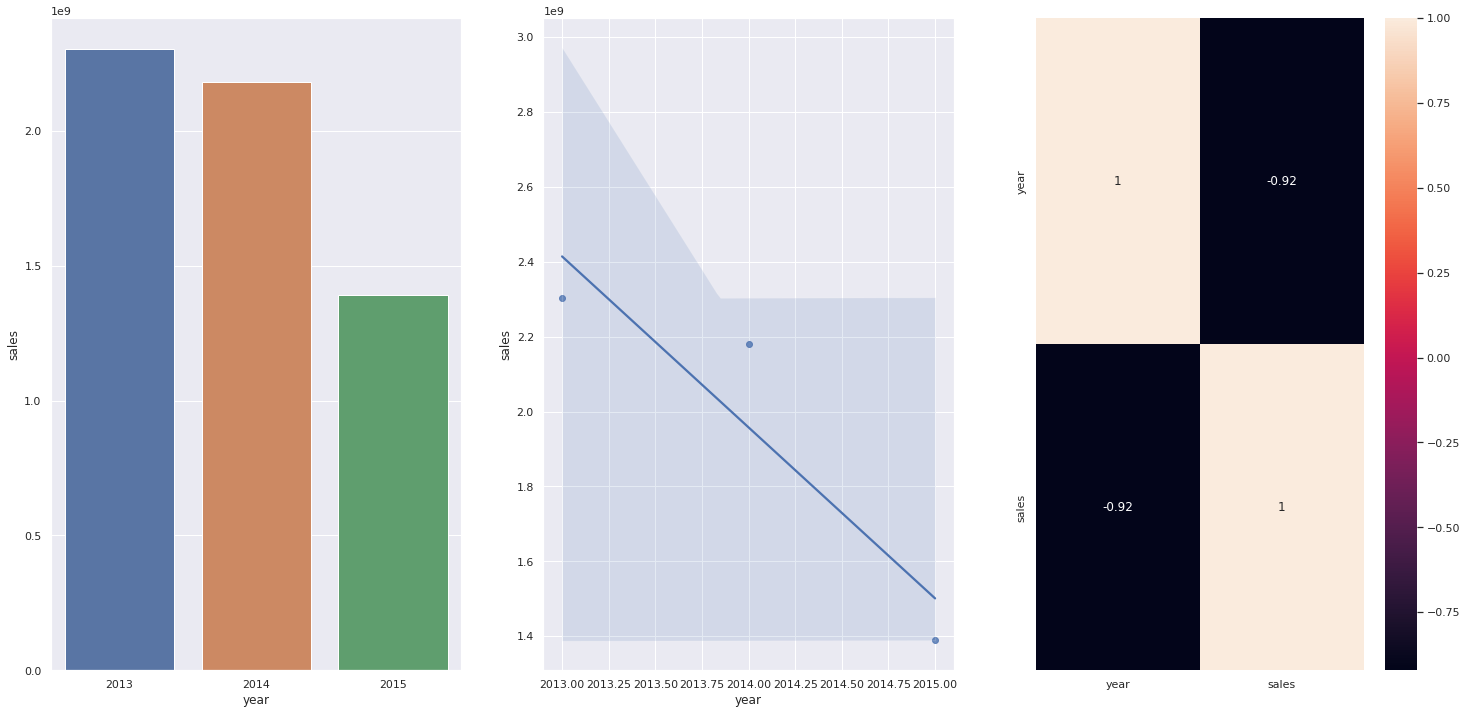

In [43]:
aux= df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x='year', y='sales', data = aux)

plt.subplot(132)
sns.regplot(x='year',y='sales', data = aux)

plt.subplot(133)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### H10. Lojas deveriam vender mais no segundo semestre do ano.

**FAlSA** Lojas vendem MENOS no segundo semestre do ano.



<AxesSubplot:>

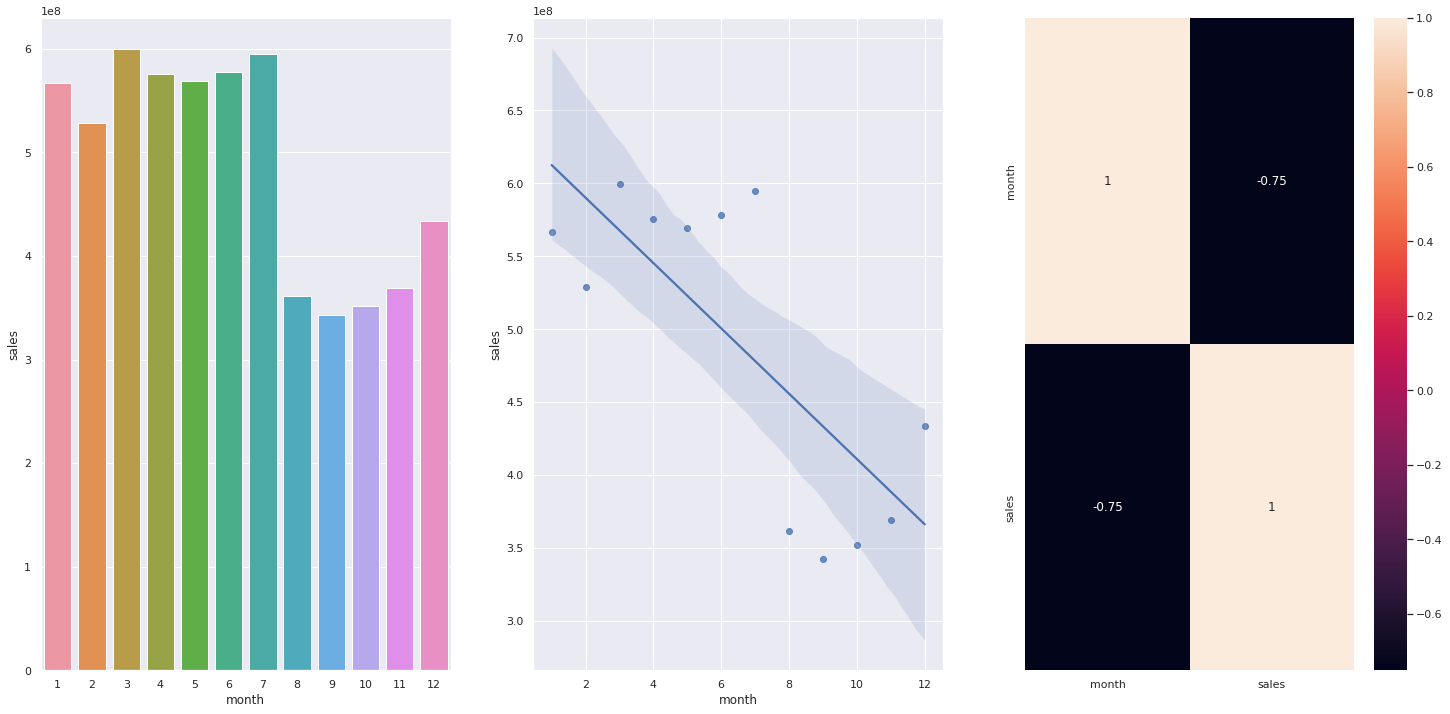

In [44]:
aux= df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(131)
sns.barplot(x='month', y='sales', data = aux)

plt.subplot(132)
sns.regplot(x='month',y='sales', data = aux)


plt.subplot(133)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.

**verdadeira** Lojas vendem MAIS depois do 10° dia do mês


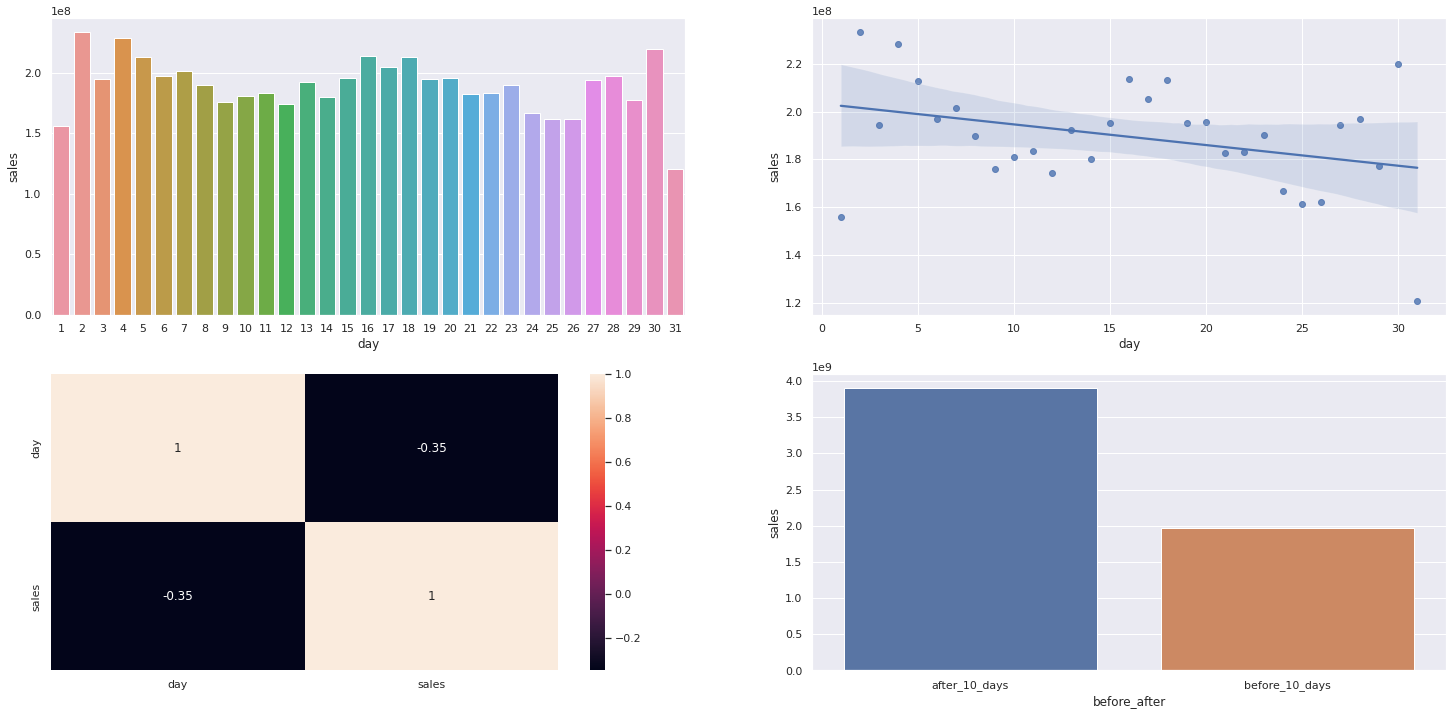

In [45]:
aux= df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(221)
sns.barplot(x='day', y='sales', data = aux)

plt.subplot(222)
sns.regplot(x='day',y='sales', data = aux)


plt.subplot(223)
sns.heatmap(aux.corr(method='pearson'), annot=True)

aux['before_after'] = aux['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')


plt.subplot(224)
aux1 = aux[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales', data = aux1);


#### H12. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem MENOS aos finais de semana


<AxesSubplot:>

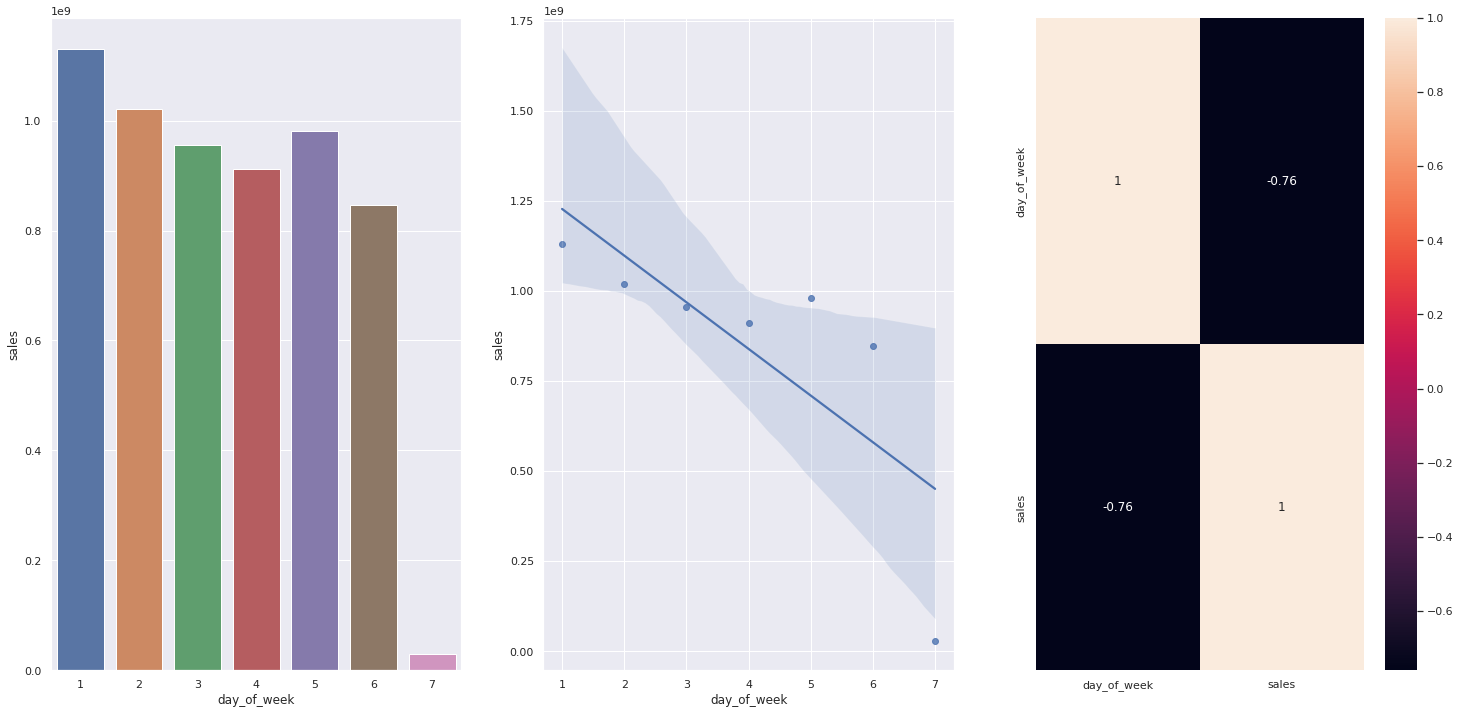

In [46]:
aux= df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(131)
sns.barplot(x='day_of_week', y='sales', data = aux)

plt.subplot(132)
sns.regplot(x='day_of_week',y='sales', data = aux)

plt.subplot(133)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### H13. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante feriados escolares, menos em Agosto.

<AxesSubplot:xlabel='month', ylabel='sales'>

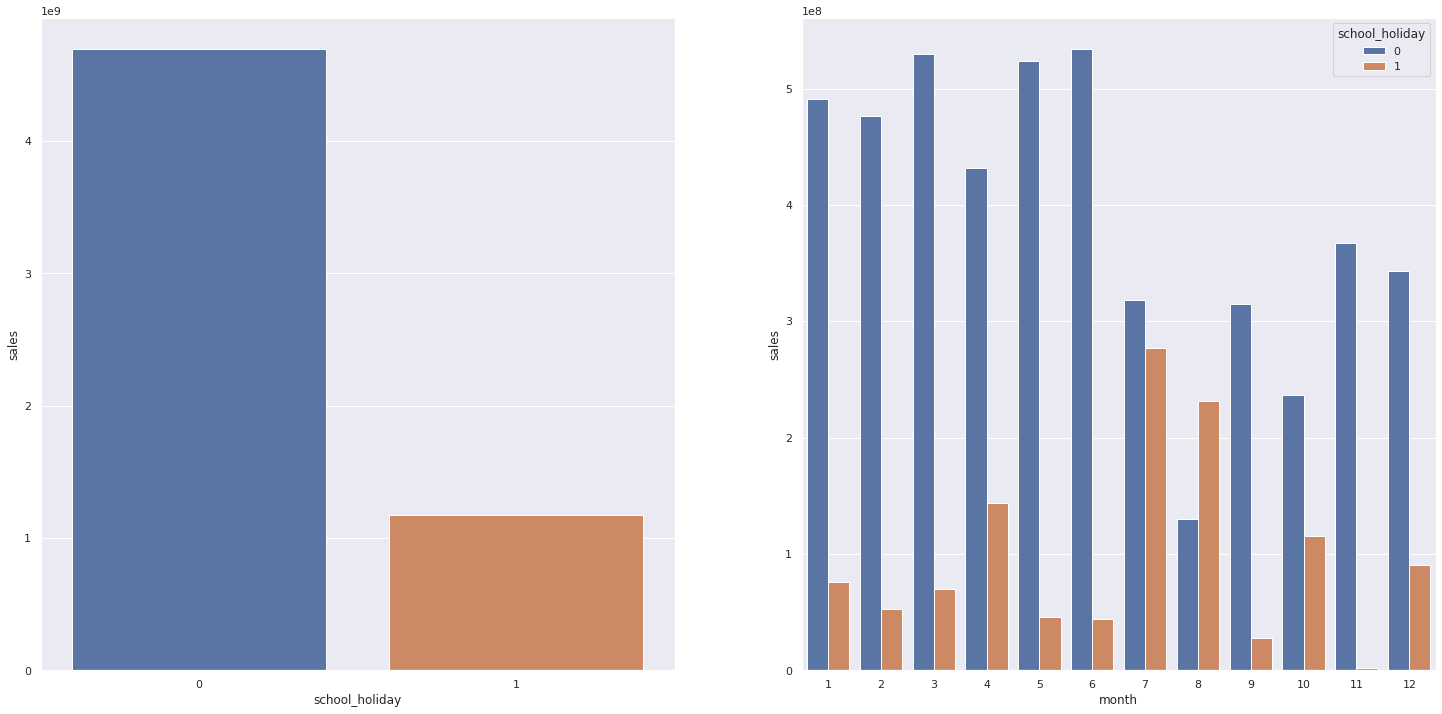

In [47]:
plt.subplot(121)
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data =aux)

plt.subplot(122)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data =aux2)

### 4.3. PASSO 04 - ANÁLISE MULTIVARIADA

 #### 4.3.1 Numerica Attributes

<AxesSubplot:>

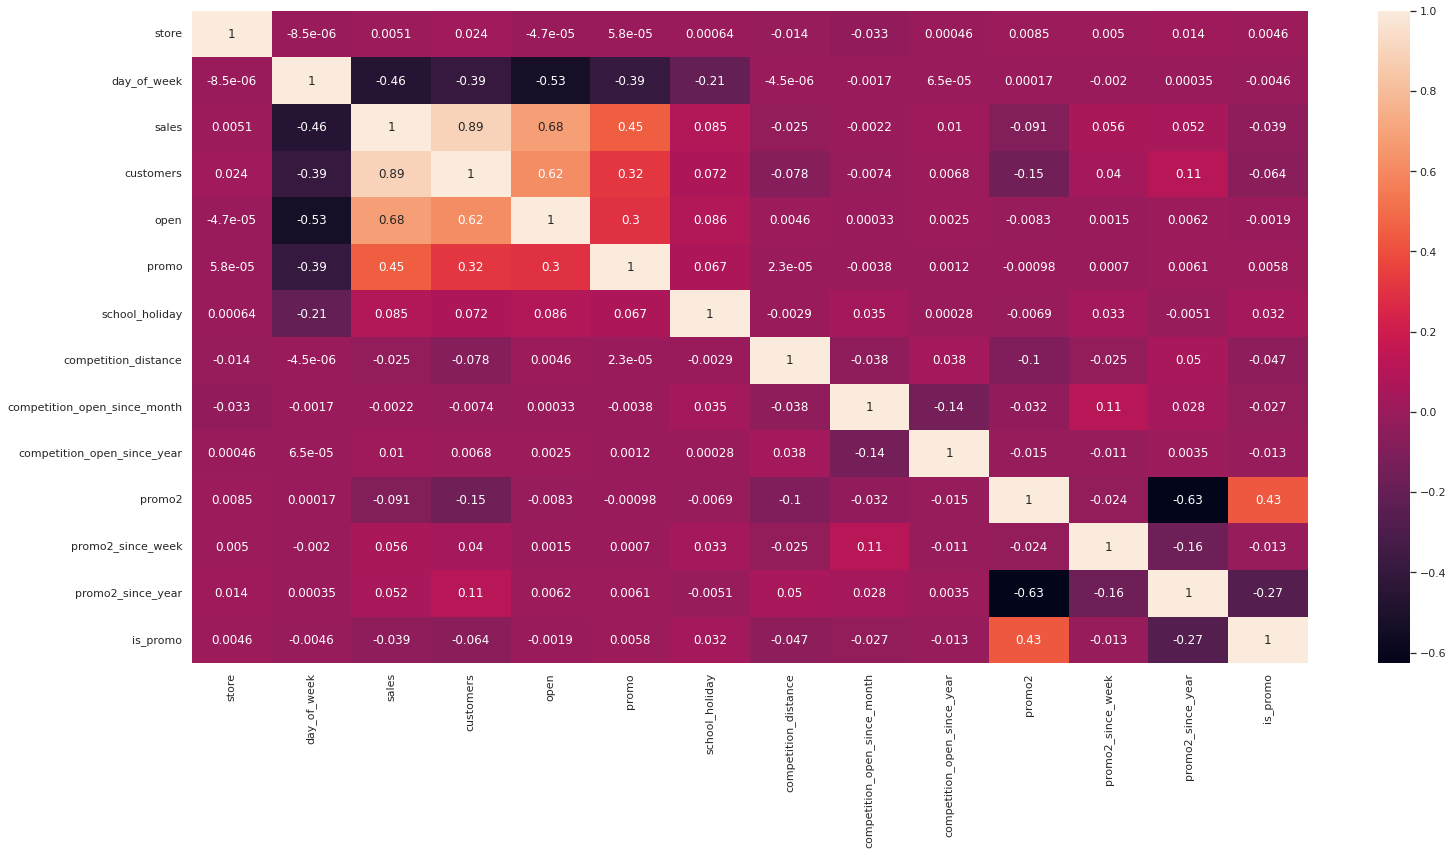

In [48]:
correlation = num_atributes.corr( method= 'pearson')
sns.heatmap(correlation, annot=True)

 #### 4.3.2 Categoical Attributes

In [49]:
a = df4.select_dtypes(include='object')

<AxesSubplot:>

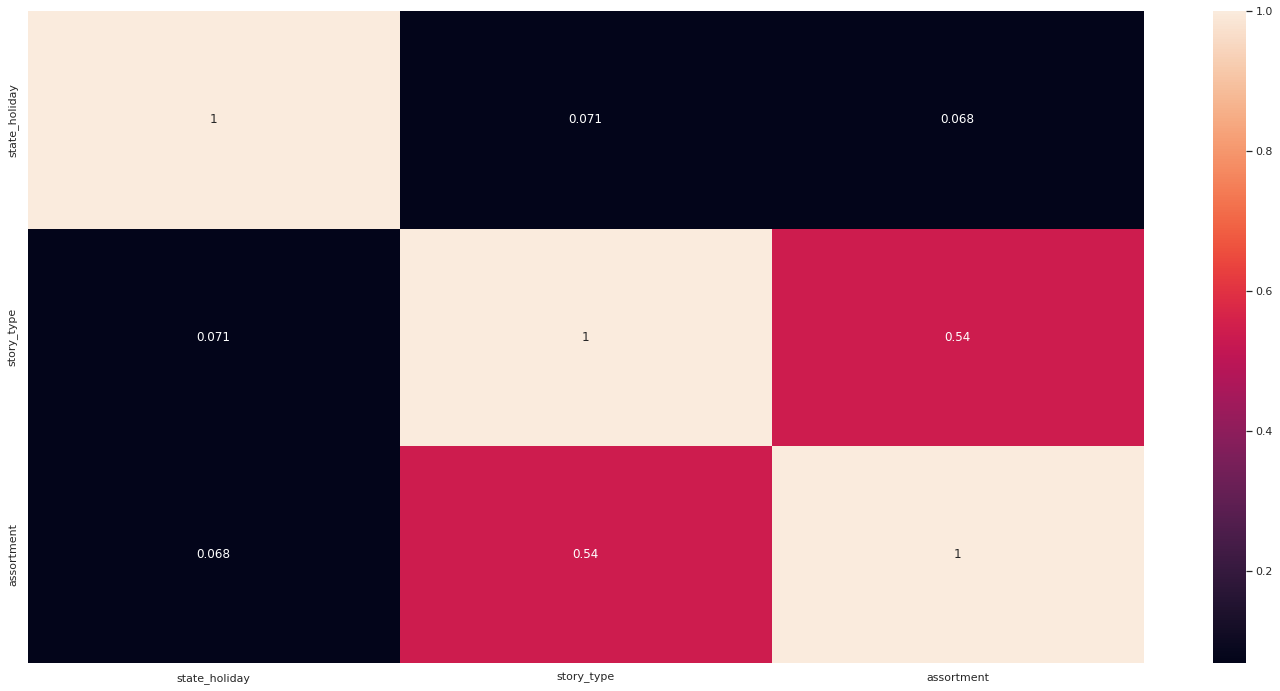

In [51]:
# Seleção de variaveis categoricas

a = df4.select_dtypes(include='object')

# calculando o cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


# Final dataset

d =pd.DataFrame( {'state_holiday' : [a1,a2,a3],
                  'story_type'    : [a4,a5,a6],
                  'assortment'    : [a7,a8,a9]})

d = d.set_index( d.columns)

# Exibe as correlações
sns.heatmap(d, annot=True)

# 5.0 PASSO 05 - DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1 Normalização

## 5.1 Rescaling

In [56]:
a = df5.select_dtypes(include=['int64','float64'])

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

In [72]:
# competition distance
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week']= mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year']= mms.fit_transform(df5[['year']].values)


## 5.3 Transformação

In [59]:
# day of week 
# year
# month
# day